## Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


### Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
try:
    import google.colab
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git
except: pass

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Preliminaries

In [4]:
try:
    import google.colab
    ! python3 -m pip install --upgrade pip
    ! pip install -q wandb
    ! pip install -q torchmetrics
    ! pip install torchsummary
except: pass

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 22.9 MB/s eta 0:00:00


#### Weights and Biases for tracking the network behavior

In [5]:
import wandb

WANDB_USER = "davidecrociati"
WANDB_PROJECT = "assignments part two"

#### Imports

In [6]:
# Standard library imports
import csv
import copy
import random
from pathlib import Path
from typing import Any, Dict
import os
import json
from datetime import datetime
import time

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
import torch.utils
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary

# Torchvision imports
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights

#### Utility functions

In [26]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def extract_classes(csv_file_path: str) -> dict:
    """
    Extract unique pairs of IDs and labels from a CSV file.

    The function reads a CSV file, extracts the third and fourth columns,
    and creates a dictionary with unique pairs of IDs (from the fourth column)
    and labels (from the third column).

    Parameters:
    csv_file_path (str): The path to the CSV file.

    Returns:
    dict: A dictionary with IDs as keys and labels as values.
    """

    # Dictionary to store the unique pairs
    classes = {}

    # Read the CSV file
    with open(csv_file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the CSV header
        next(csv_reader)

        for row in csv_reader:
            label = row[2]       # Third column
            id = int(row[3])     # Fourth column

            # Add the pair to the dictionary if it doesn't already exist
            if id not in classes:
                classes[id] = label

    return classes

def parse_compose(v):
  """
    Parse composition of data transformation and model structure.
  """
  res = []
  for t in str(v).split("\n")[1:]:
    res.append(t.strip("    "))
  return res[:-1]

### Configuration

Initially we fix all the possible source of randomness, we check if there is a GPU available and set the initial parameters for the neural network. We will work with 224x224 images, using Adam optimizer and cross entropy loss with batch_size of 32 images.

In [8]:
fix_random(seed=42)

device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

cfg = {
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 20,
    "optimizer":Adam,
    "optimizer_params":{
      "lr": 1e-3,
    },
    "loss":F.cross_entropy,
    "loss_params":{}
}

INPUT_DIM=(3, cfg["crop_size"], cfg["crop_size"])

All good, a GPU is available


### Data

We extract the classes from the csv file and we resize the images to 224x224. Then we create the data loaders for validation and train sets.

In [9]:
# In  order to convert integer classes into their literal
classes = extract_classes(csv_file_path = 'GroceryStoreDataset/dataset/classes.csv')

data_resizing = T.Compose([
                        T.Resize((cfg["crop_size"],cfg["crop_size"])),
                        T.ToTensor()
                    ])

data_train = GroceryStoreDataset(split="train", transform=data_resizing)
data_val = GroceryStoreDataset(split="val", transform=data_resizing)

In [10]:
# For automating batching

loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)

### Trainer

In [29]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            configuration: dict,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        """
        Initializes the class with the given parameters and sets up the training environment.

        Args:
            model (nn.Module): The neural network model to be trained.
            configuration (dict): A dictionary containing configuration settings, such as the optimizer,
                                  scheduler, num_epochs, lr.
            train_loader (DataLoader): The DataLoader for the training dataset.
            val_loader (DataLoader): The DataLoader for the validation dataset.
            device (torch.device): The device on which the model and data will be processed.
            num_classes (int): The number of output classes in the classification task.
        """

        self.train_loader = train_loader
        self.cfg = configuration
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = self.cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = self.cfg["optimizer"](self.model.parameters(), **self.cfg["optimizer_params"])

        if self.cfg.setdefault("scheduler", None):  # set learning  rate scheduler if any
            num_steps = self.num_epochs * len(train_loader)
            self.scheduler = self.cfg["scheduler"](self.optimizer, self.cfg["optimizer_params"]["lr"], total_steps=num_steps, **self.cfg["scheduler_params"])

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=self.cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=self.cfg)  # initialize wand run
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        """
        Logs the provided metrics and information to Weights and Biases (wandb).

        Args:
            values (Dict[str, Any]): A dictionary of values to log. The keys are the names of the metrics.
        """
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        """
        Trains the neural network model over a specified number of epochs, logging metrics and evaluating performance.
        """
        self.training_time = time.time()
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs) # Predict batch
                loss = F.cross_entropy(pred, labels)  # Compute the loss

                self.optimizer.zero_grad()
                loss.backward() # Backpropagate the loss to compute gradients
                self.optimizer.step()
                if self.cfg["scheduler"]: # Update the learning rate scheduler, if any
                    self.scheduler.step()

                if self.step % 10 == 0: # Log the training loss and learning rate every 10 steps
                    self.logfn({"train/loss": loss.item()})
                    if self.cfg["scheduler"]:
                        self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})
                    else:
                        self.logfn({"train/lr": self.cfg["optimizer_params"]["lr"]})

                self.step += 1

            self.eval("train")  # Evaluate the model on the training and validation after each epoch
            self.eval("val")

        wandb.finish() # Finish the wandb run
        self.training_time = time.time() - self.training_time # Record total training time

    @torch.no_grad()
    def eval(self, split: str) -> None:
        """
        Evaluates the neural network model on the specified dataset split (either 'train' or 'val')
        and logs the performance metrics.
        """
        self.model.eval() # Set the model to evaluation mode

        if split == "train":   # Select the right DataLoader
            loader = self.train_loader
        elif split == "val":
            loader = self.val_loader
        else:
            raise ValueError(f"Unknown split: {split}")

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = self.cfg["loss"](pred, labels, **self.cfg["loss_params"])
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1) # Compute softmax on the predictions to get class probabilities
            acc(pred_softmax, labels) # Update accuracy

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val": # Save the best model
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    def save_model_params(self, data_transforms=None):
        """
        Saves the model's configuration, data transformations, and structure to a JSON file.
        """
        model_dir = os.path.join("params", f"{self.cfg['run_name']}_model")
        os.makedirs(model_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        training_time_formatted = time.strftime('%H-%M-%S', time.gmtime(self.training_time))
        file_name = f"ACC={self.best_acc:.2f}____TT={training_time_formatted}____TM={timestamp}.json"
        file_path = os.path.join(model_dir, file_name)

        cfg={c:str(self.cfg[c]) for c in self.cfg}
        combined_params = {
            "cfg": cfg,
            "data_transforms": parse_compose(data_transforms) if data_transforms else None,
            "model_structure" : parse_compose(self.model)
        }

        with open(file_path, 'w') as f:
            json.dump(combined_params, f, indent=4)

### Models

Now that the training functionalities are set up, we can start to introduce our models for the given problem.


#### V1: Simplest model

One very simple model to start can be composed by just:
- 2 conv layers
- Max pooling
- 1 FC layer

In [13]:
class V1(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(V1, self).__init__()
        self.input_dim = input_dim

        ## Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x=self._forward(x)
        self._to_linear = x.numel()

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._forward(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
model = V1(n_classes=len(classes),input_dim=INPUT_DIM[1:])
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=INPUT_DIM
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,736
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          51,264
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                   [-1, 43]         539,435
Total params: 595,435
Trainable params: 595,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.31
Params size (MB): 2.27
Estimated Total Size (MB): 7.15
----------------------------------------------------------------


In [15]:
cfg["run_name"] = "v1"

trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▄▆▇▇▇██████████████
train/loss,█▆▅▄▄▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▆▄█▅▇▇▆▇▆▇▅▇▂▆▆▇▆▆▆
val/loss,▁▁▂▂▃▃▃▄▄▃▄▅▄█▅▅▅▅▅▅
train/acc,1.0
train/loss,0.00033
train/lr,0.001
val/acc,0.32095
val/loss,6.07373


Best val acc = 0.365


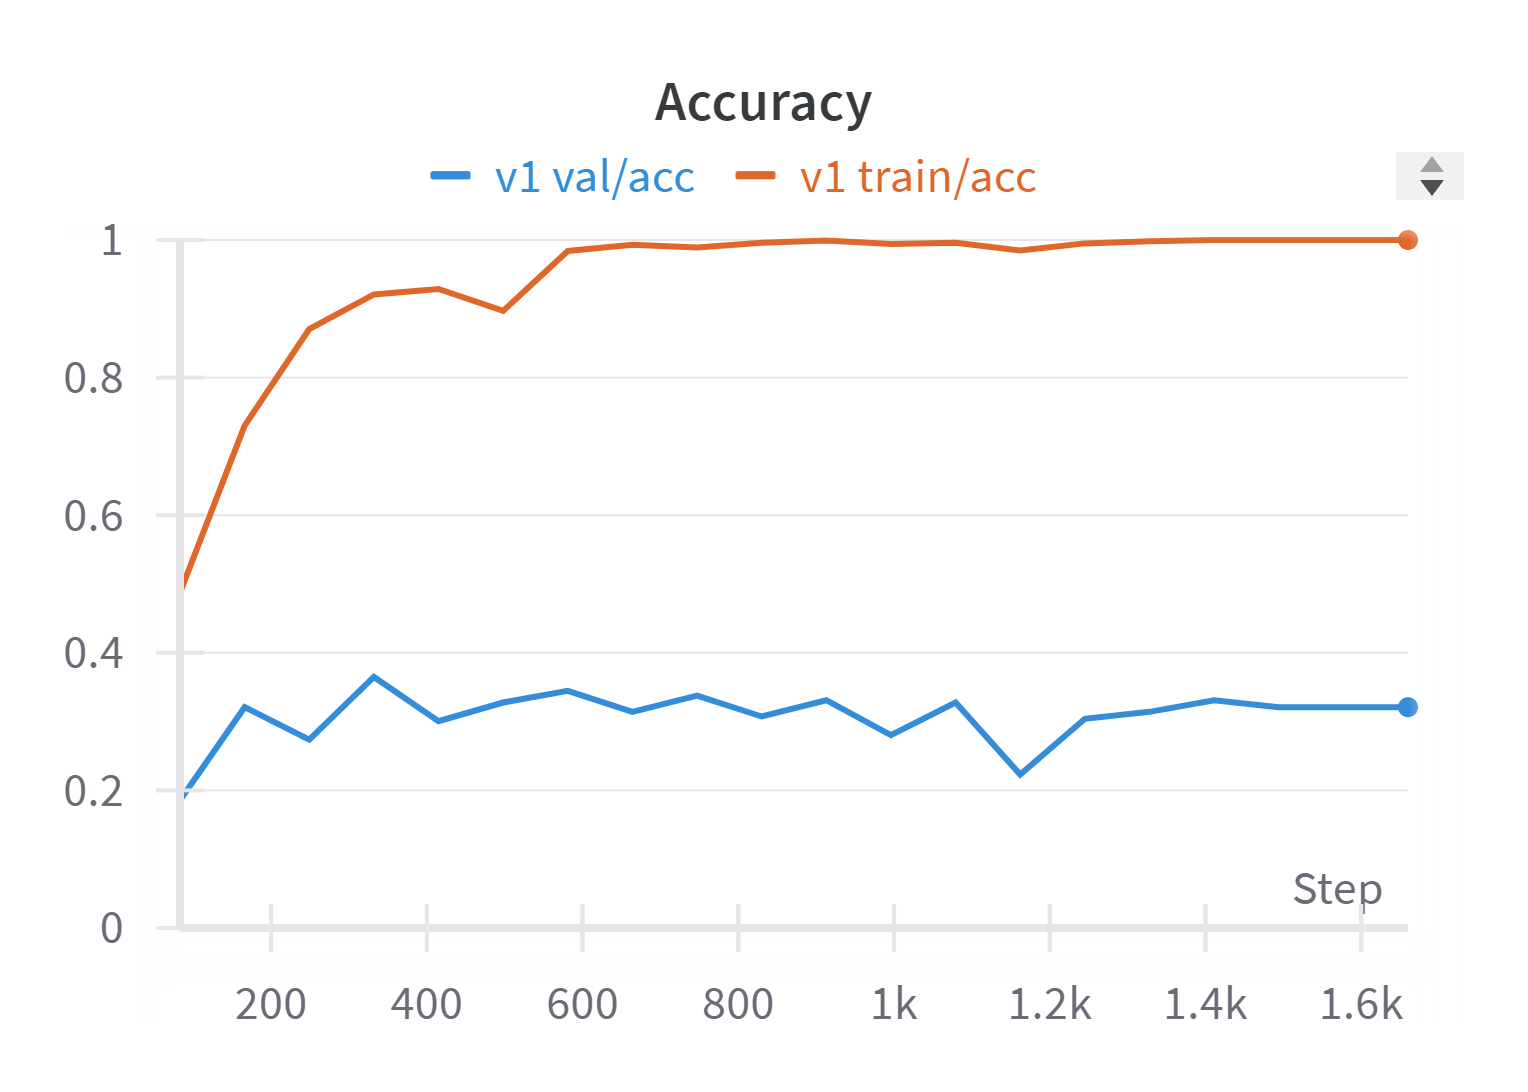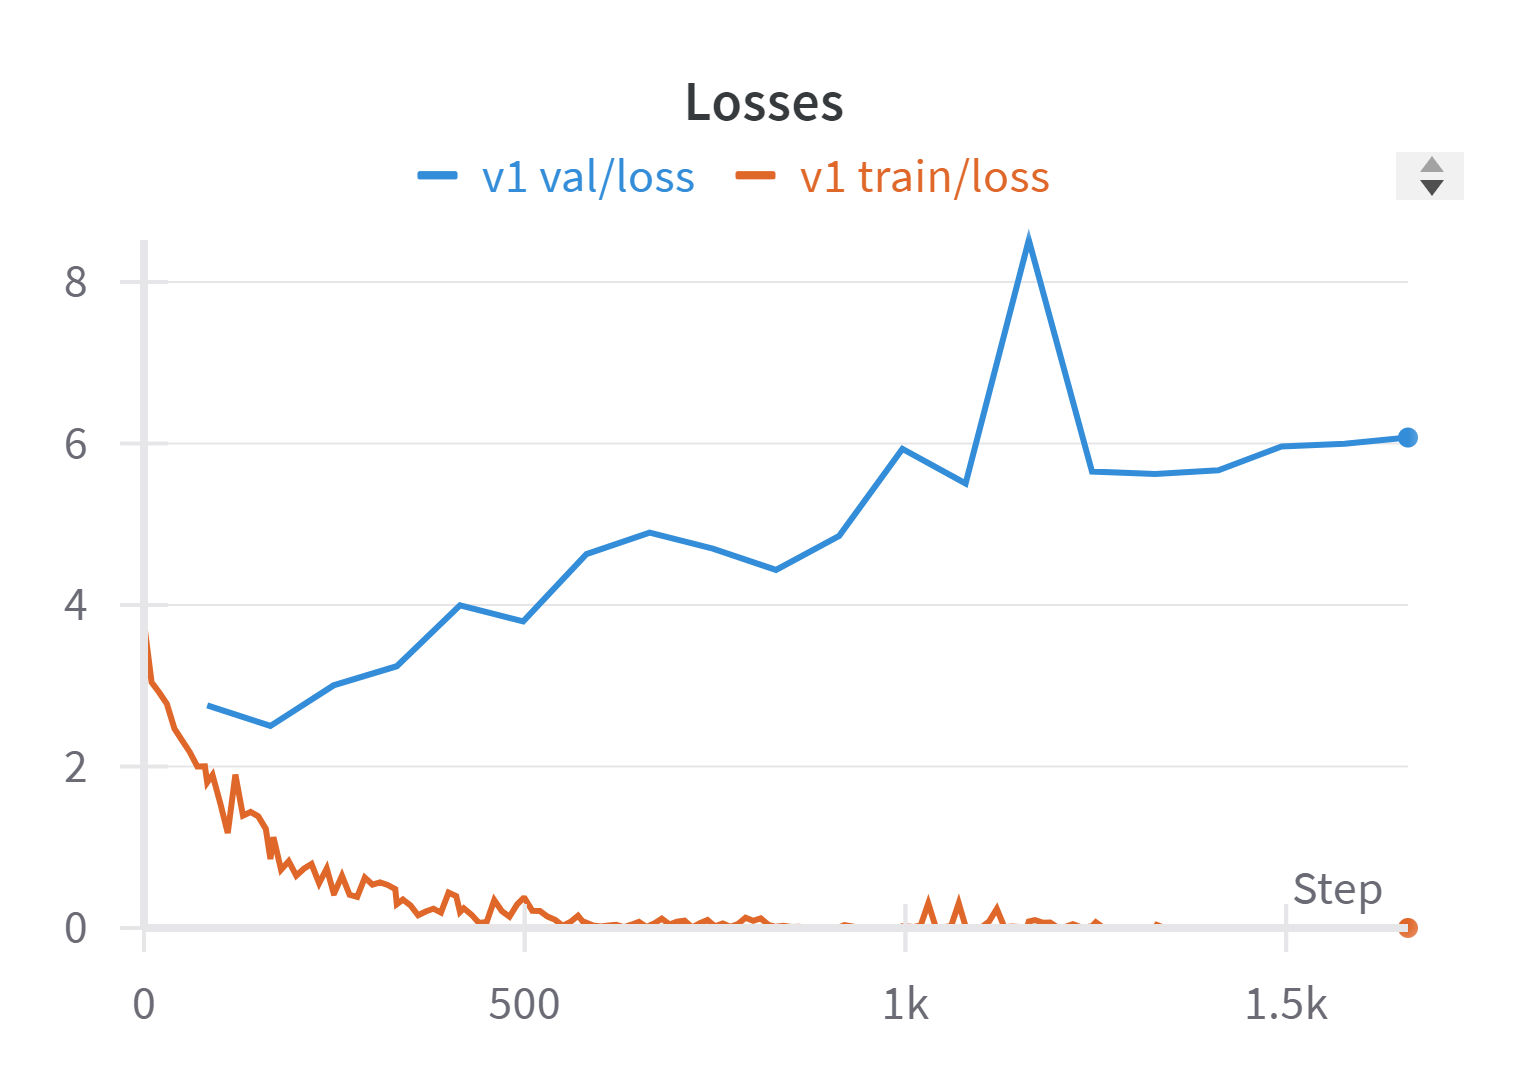

As we can clearly see the model is overfitting very fast(less than 10 epochs). Obviously this model is too simple and it cannot generalize on the validation set. We should increase the model complexity to try to decrease the validation loss.

#### V2: Add layers

The second model is constituted by:
- Stem layer with one 7x7 convolution and 1 max pooling layer
- Four 3x3 convolution that decrease the spatial dimension and increase the number of channels until 512
- Three FC layers for the classifier

In [34]:
class V2(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(V2, self).__init__()
        self.input_dim=input_dim

        # Stem Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=1)
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)

        # FC classifier
        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x=self._forward(x)
        self._to_linear = x.numel()

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x

    def forward(self, x):
        x = self._forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
model = V2(n_classes=len(classes),input_dim=INPUT_DIM[1:])
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=INPUT_DIM
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 110, 110]           4,736
         MaxPool2d-2           [-1, 32, 55, 55]               0
            Conv2d-3           [-1, 64, 55, 55]          18,496
            Conv2d-4          [-1, 128, 28, 28]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
            Conv2d-6            [-1, 512, 7, 7]       1,180,160
            Linear-7                  [-1, 512]      12,845,568
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 43]          11,051
Total params: 14,560,363
Trainable params: 14,560,363
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.52
Params size (MB): 55.54
Estimated Total Size (MB): 62.63
-----------------------------------

We can notice that the number of parameters has increased by a lot due to the introduction of the 2 additional FC layers.

In [ ]:
cfg["run_name"] = "v2"

trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params()

wandb: Currently logged in as: davide-crociati01 (davidecrociati). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▂▃▃▄▅▆▆▇███████████
train/loss,██▇▇▆▆▆▆▅▅▅▄▄▄▃▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▅▅▅▅▆▅▇▆▇▇▇▅▆▇▆█▆▅█
val/loss,▂▁▁▁▁▁▂▂▃▃▅▅▆▆▅▇▇█▇▆
train/acc,0.99356
train/loss,0.02517
train/lr,0.001
val/acc,0.23986
val/loss,7.43625


Best val acc = 0.240


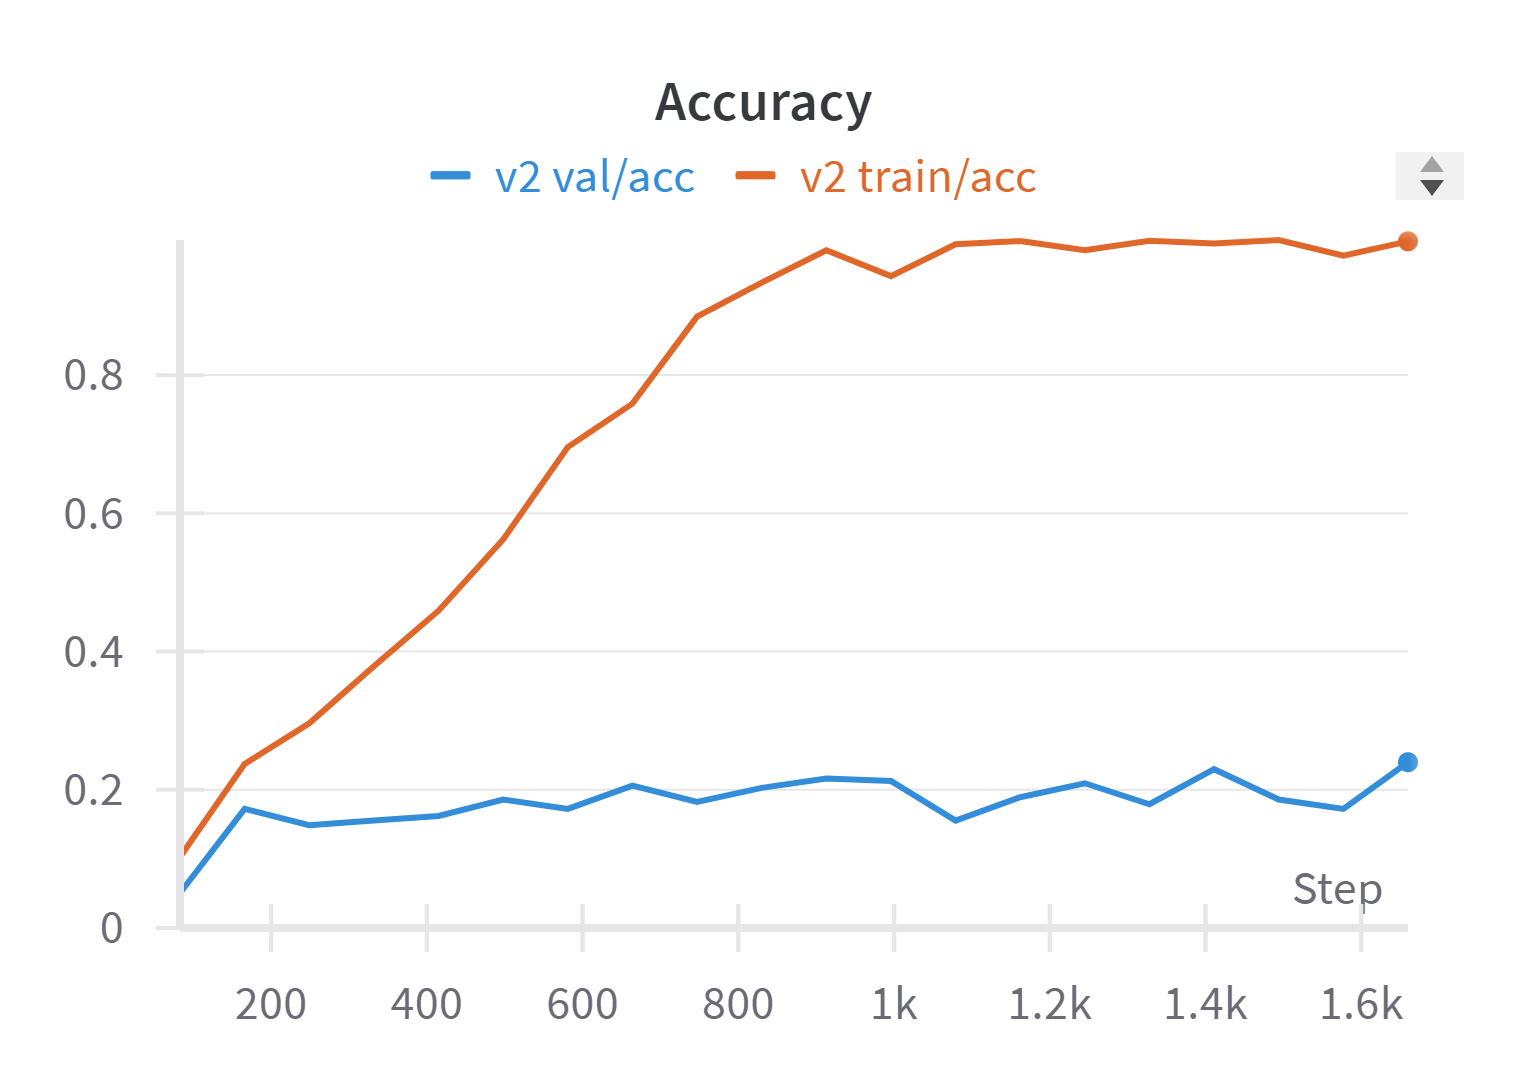

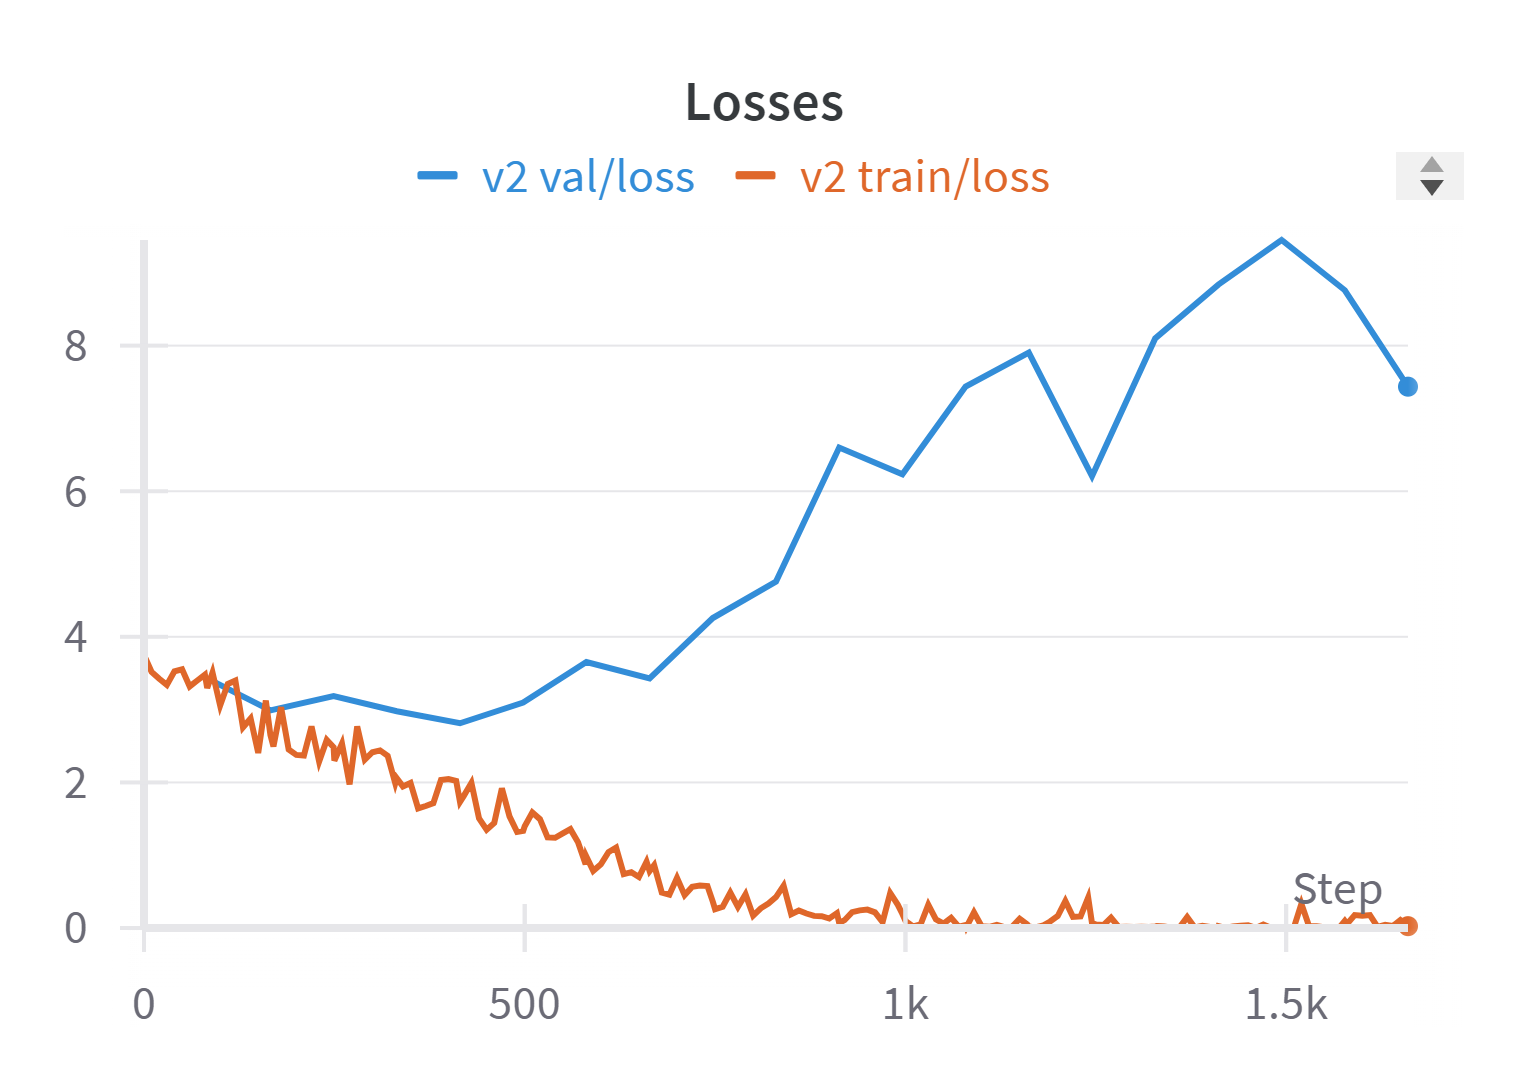

We can deduce that also this second model is too simple. It need some more epoch to overfit but it still has a very low accuracy (and high loss) on the validation set. We can try to increase again the depth of the network, but being careful with the number of parameters.

#### V3: Deeper model

The third model is constituted by:
- Stem layer with one 7x7 convolution and 1 max pooling layer
- Eight 3x3 convolution that decrease the spatial dimension and increase the number of channels until 512
- Global AVG pooling to avoid the explosion of the parameters number
- Three FC layers for the classifier

In [19]:
class V3(nn.Module):
    def __init__(self, n_classes):
        super(V3, self).__init__()

        # Stem layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Convolutional layers
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)


        self.globalpool = nn.AdaptiveAvgPool2d(1)

        # FC classifier
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        return x

    def forward(self, x):
        x = self._forward(x)
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
model = V3(n_classes=len(classes))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=INPUT_DIM
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
         MaxPool2d-2           [-1, 64, 55, 55]               0
            Conv2d-3           [-1, 64, 55, 55]          36,928
            Conv2d-4           [-1, 64, 55, 55]          36,928
            Conv2d-5          [-1, 128, 28, 28]          73,856
            Conv2d-6          [-1, 128, 28, 28]         147,584
            Conv2d-7          [-1, 256, 14, 14]         295,168
            Conv2d-8          [-1, 256, 14, 14]         590,080
            Conv2d-9            [-1, 512, 7, 7]       1,180,160
           Conv2d-10            [-1, 512, 7, 7]       2,359,808
AdaptiveAvgPool2d-11            [-1, 512, 1, 1]               0
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 256]         131,328
           Linear-14                   

We can see that the number of parameters is lower than before even if we increased the depth, thanks to the introduction of the gloabal avg pooling. Without this layer we would have obtained more than 30 million parameters.

With this new network it has been necessary to introuduce a small warmup (5 epochs) with a lower learning rate. Without that the network had some difficulties in the convergence.

In [21]:
cfg["run_name"] = "v3_warmup"
cfg["num_epochs"] = 5
cfg["optimizer_params"]["lr"] = 1e-4
trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train/acc,▂▄▁▄█
train/loss,██▆▅▅▃▅▄▄▅▅█▂▄▅▅▄▅▅▃▄▄▆▄▄▅▃▇▄▆▅▅▃▃▁▄▆▂▄▂
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,█▄▁▄▆
val/loss,██▇▆▁
train/acc,0.12841
train/loss,3.18306
train/lr,0.0001
val/acc,0.08784
val/loss,3.3188


As the network grow in depth, a longer training became both possible and necessary.

In [22]:
cfg["run_name"] = "v3"
cfg["num_epochs"] = 50
cfg["optimizer_params"]["lr"] = 1e-3
trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params()

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train/acc,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█▇████
train/loss,█████▇██▇▇▇▇▆▆▆▅▆▅▅▆▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▂▂▂▂▂▂▂▄▂▇▆▅▆▅▅▆▅▅▅▆▅▇█▆▆▆▇▆▇▇█▇▇▆▇▆▇
val/loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▂▂▁▂▃▃▃▂▃▄▅▅▆▄▇▇▅█
train/acc,0.94848
train/loss,0.15732
train/lr,0.001
val/acc,0.23311
val/loss,7.91012


Best val acc = 0.264


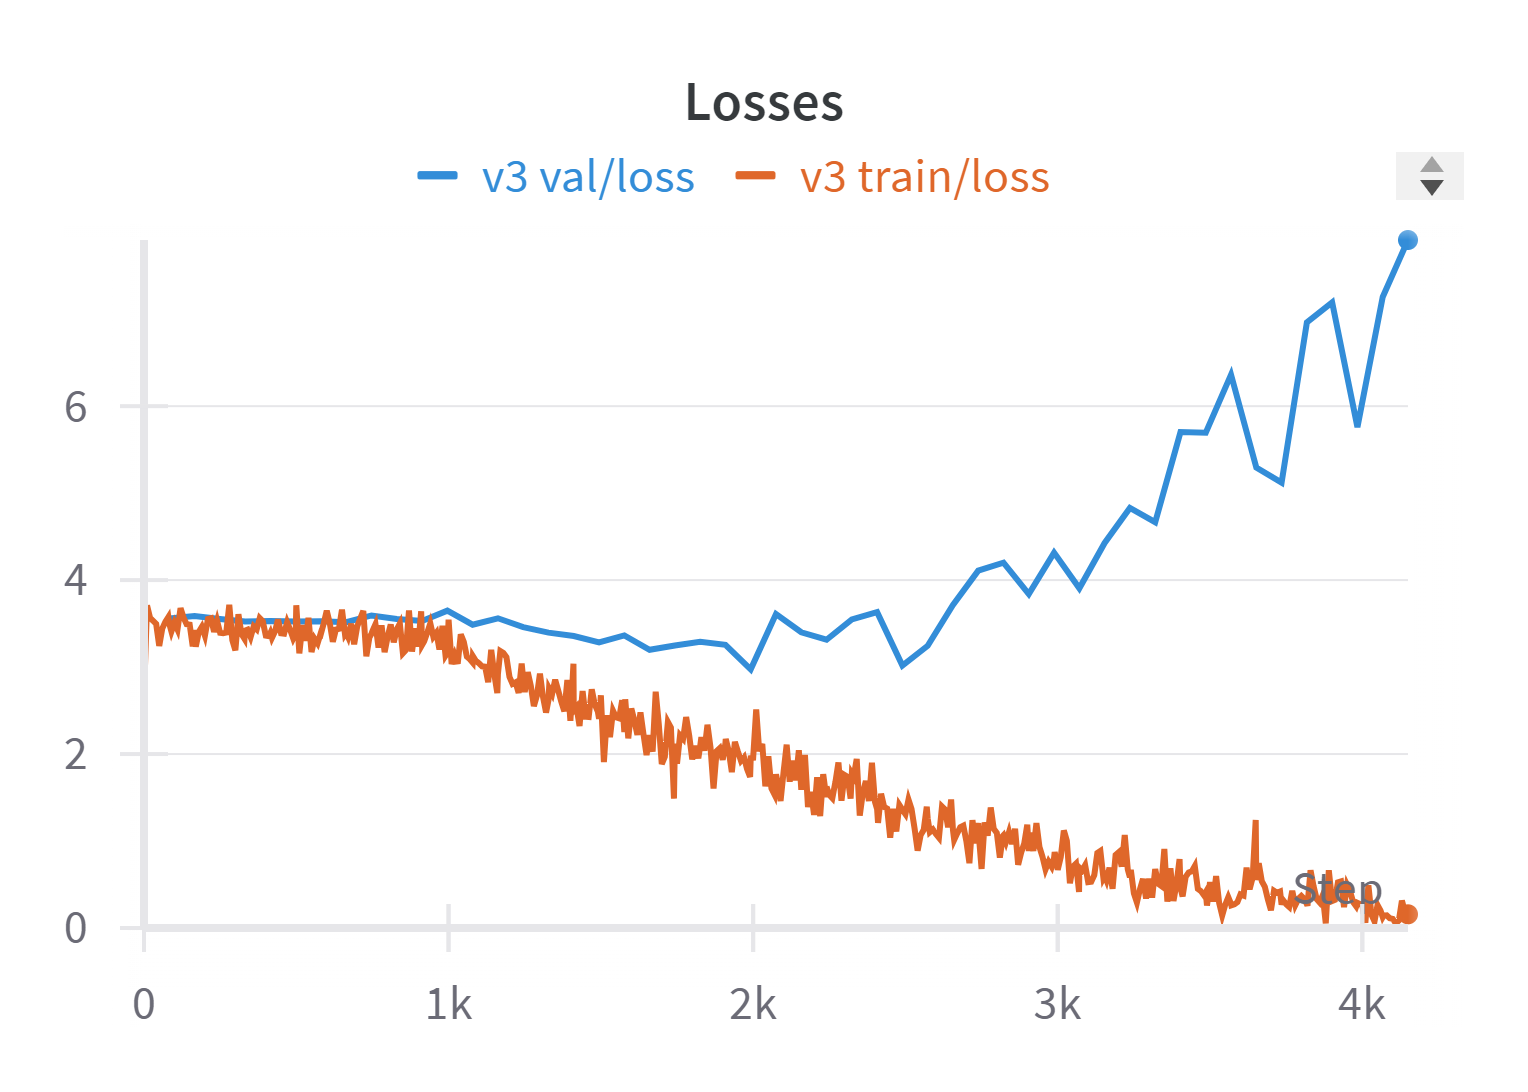

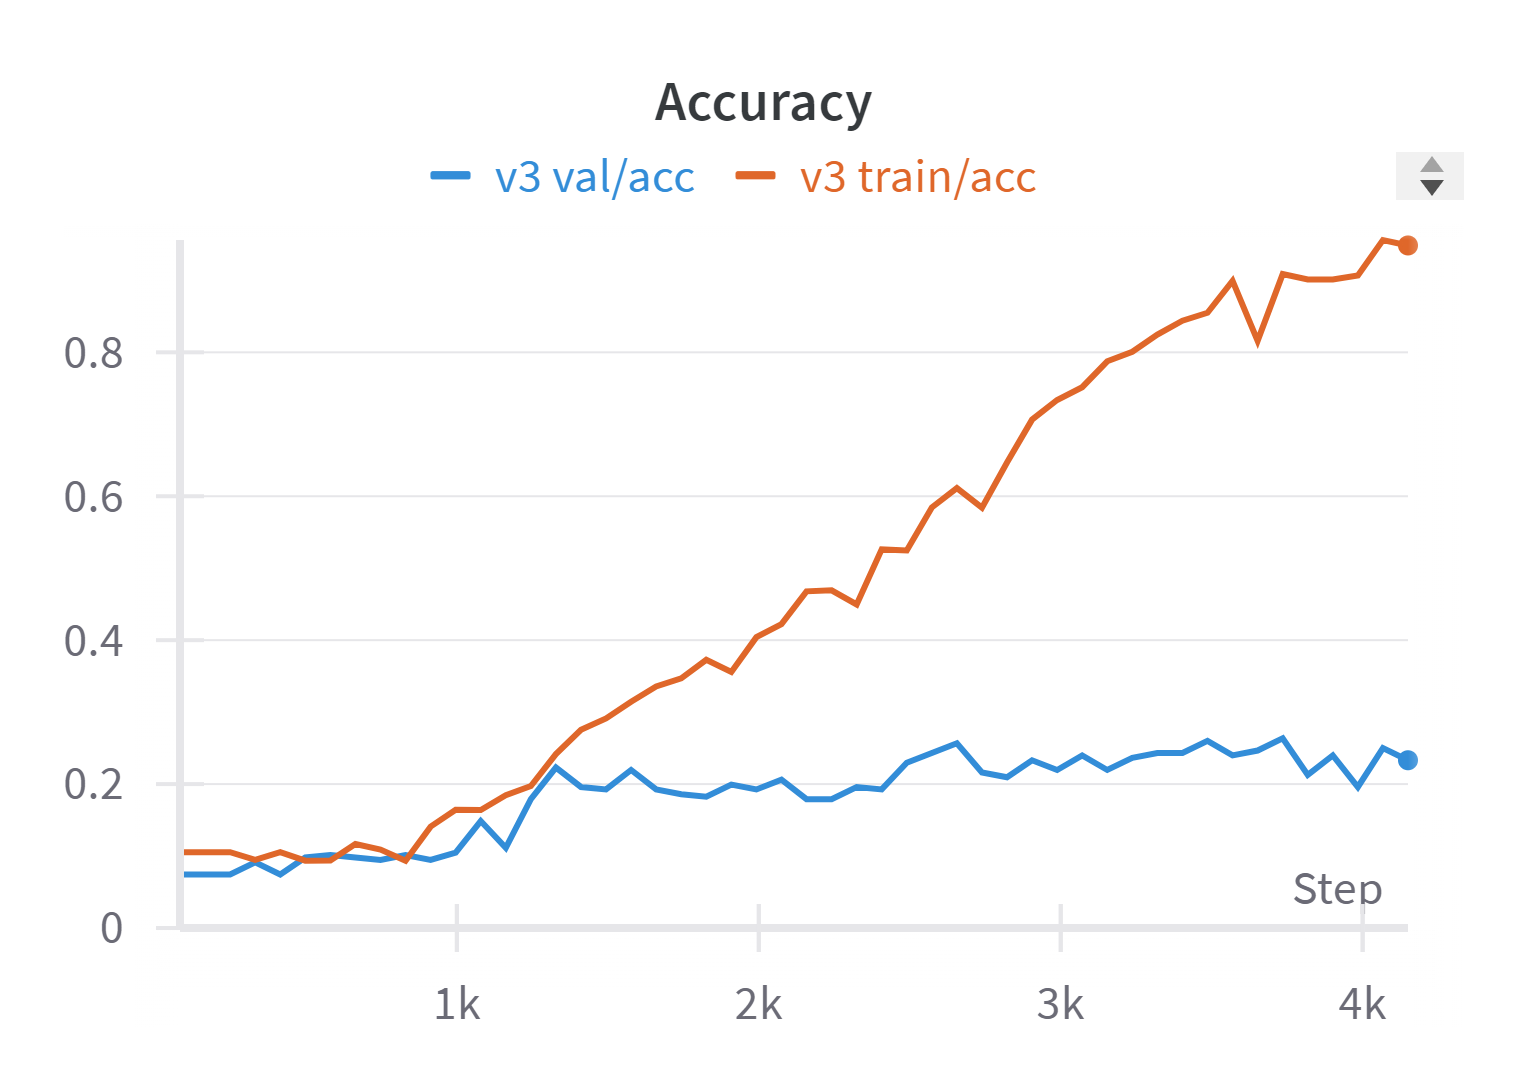

We can see that we are reaching a low training loss in a lot more epochs, but the validation accuracy it's still pretty low.
We can try to make the training more stable and faster adding Batch Normalization after each convolutional layer.

#### V4: Introduce Batch-Norm

This model is the same as before but with a batch normalization layer after each convolution.

In [23]:
class V4(nn.Module):
    def __init__(self, n_classes):
        super(V4, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm2d(512)

        self.globalpool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        return x

    def forward(self, x):
        x = self._forward(x)
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [24]:
model = V4(n_classes=len(classes))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=INPUT_DIM
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
       BatchNorm2d-2         [-1, 64, 110, 110]             128
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 64, 55, 55]          36,928
       BatchNorm2d-5           [-1, 64, 55, 55]             128
            Conv2d-6           [-1, 64, 55, 55]          36,928
       BatchNorm2d-7           [-1, 64, 55, 55]             128
            Conv2d-8          [-1, 128, 28, 28]          73,856
       BatchNorm2d-9          [-1, 128, 28, 28]             256
           Conv2d-10          [-1, 128, 28, 28]         147,584
      BatchNorm2d-11          [-1, 128, 28, 28]             256
           Conv2d-12          [-1, 256, 14, 14]         295,168
      BatchNorm2d-13          [-1, 256, 14, 14]             512
           Conv2d-14          [-1, 256,

In [25]:
cfg["run_name"] = "v4"
cfg["num_epochs"] = 100
trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train/acc,▁▁▃▂▃▄▂▄▅▄▅▃▃▇▆▅▅▆▇▇▇▇█▇█▇▇██▇▇█▇███▇██▇
train/loss,▇█▅▅▅▄▄▄▄▃▄▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▃▁▄▂▃▃▂▆▅▂▅▂▆▆▆▇▇▆█▇▆▇▆▇█▇█▇▇▅█▇▇██▇▆▇▇▆
val/loss,▃▄▂▃▃▂▆▁▂█▃██▃▃▃▄▅▃▃▄▄▄▅▄▅▅▄▄█▄▄▄▄▅▅▆▇▅▇
train/acc,0.93523
train/loss,0.23697
train/lr,0.001
val/acc,0.35473
val/loss,4.46692


Best val acc = 0.500


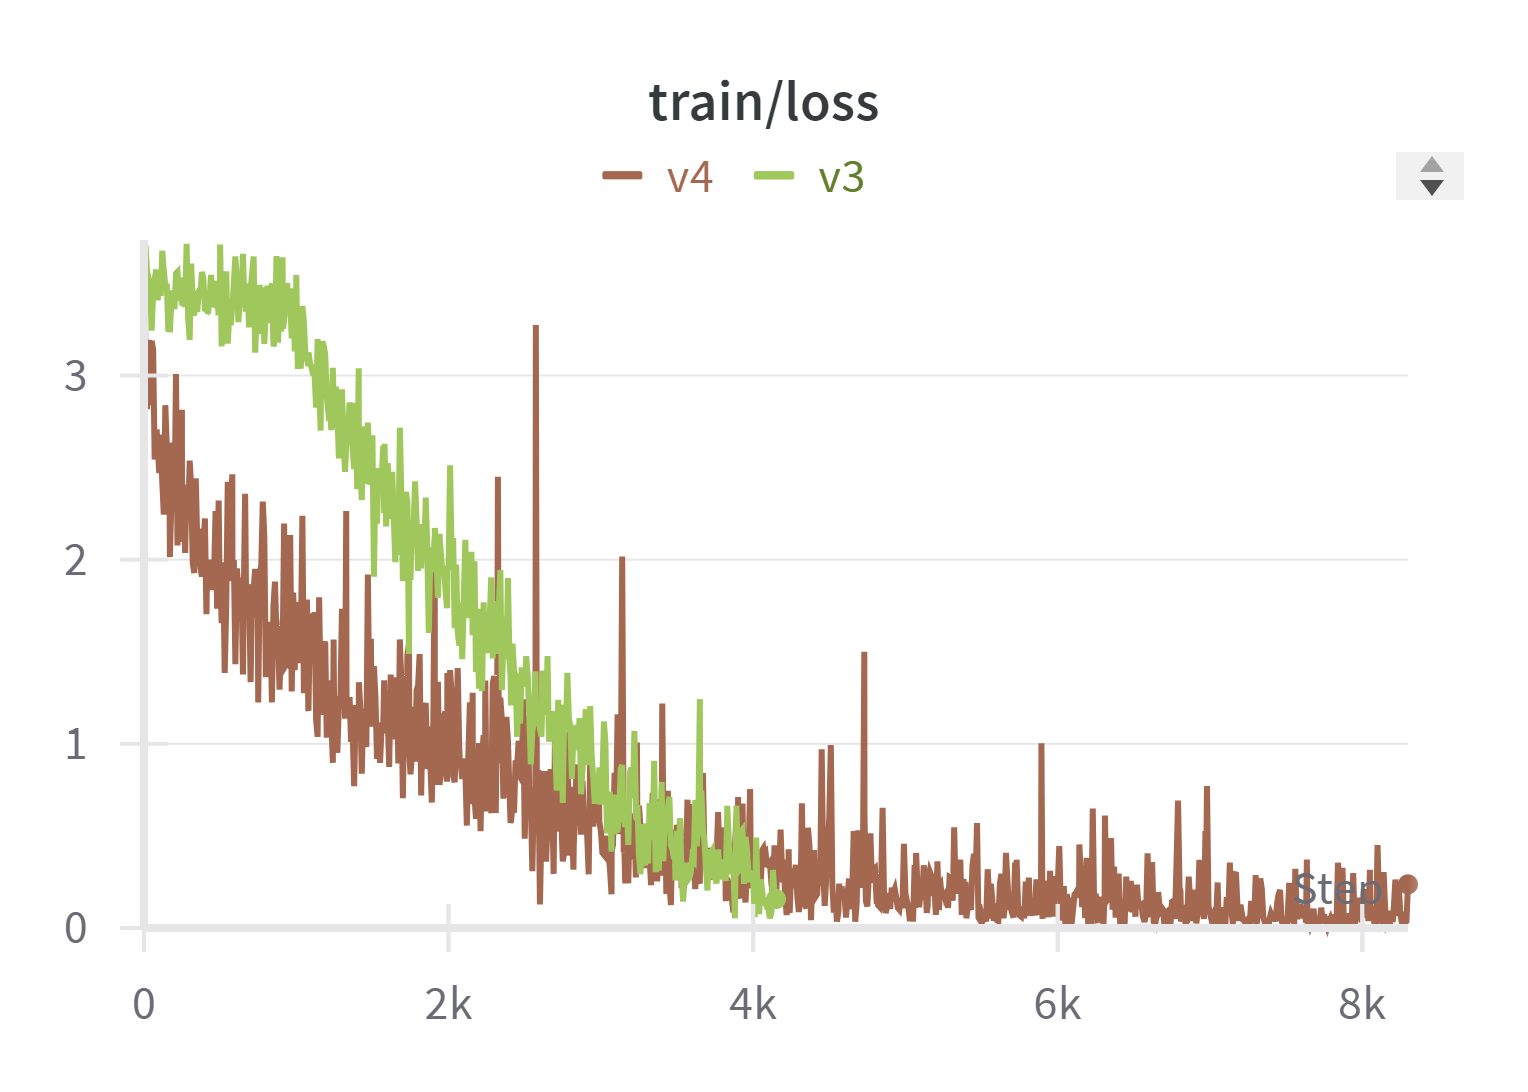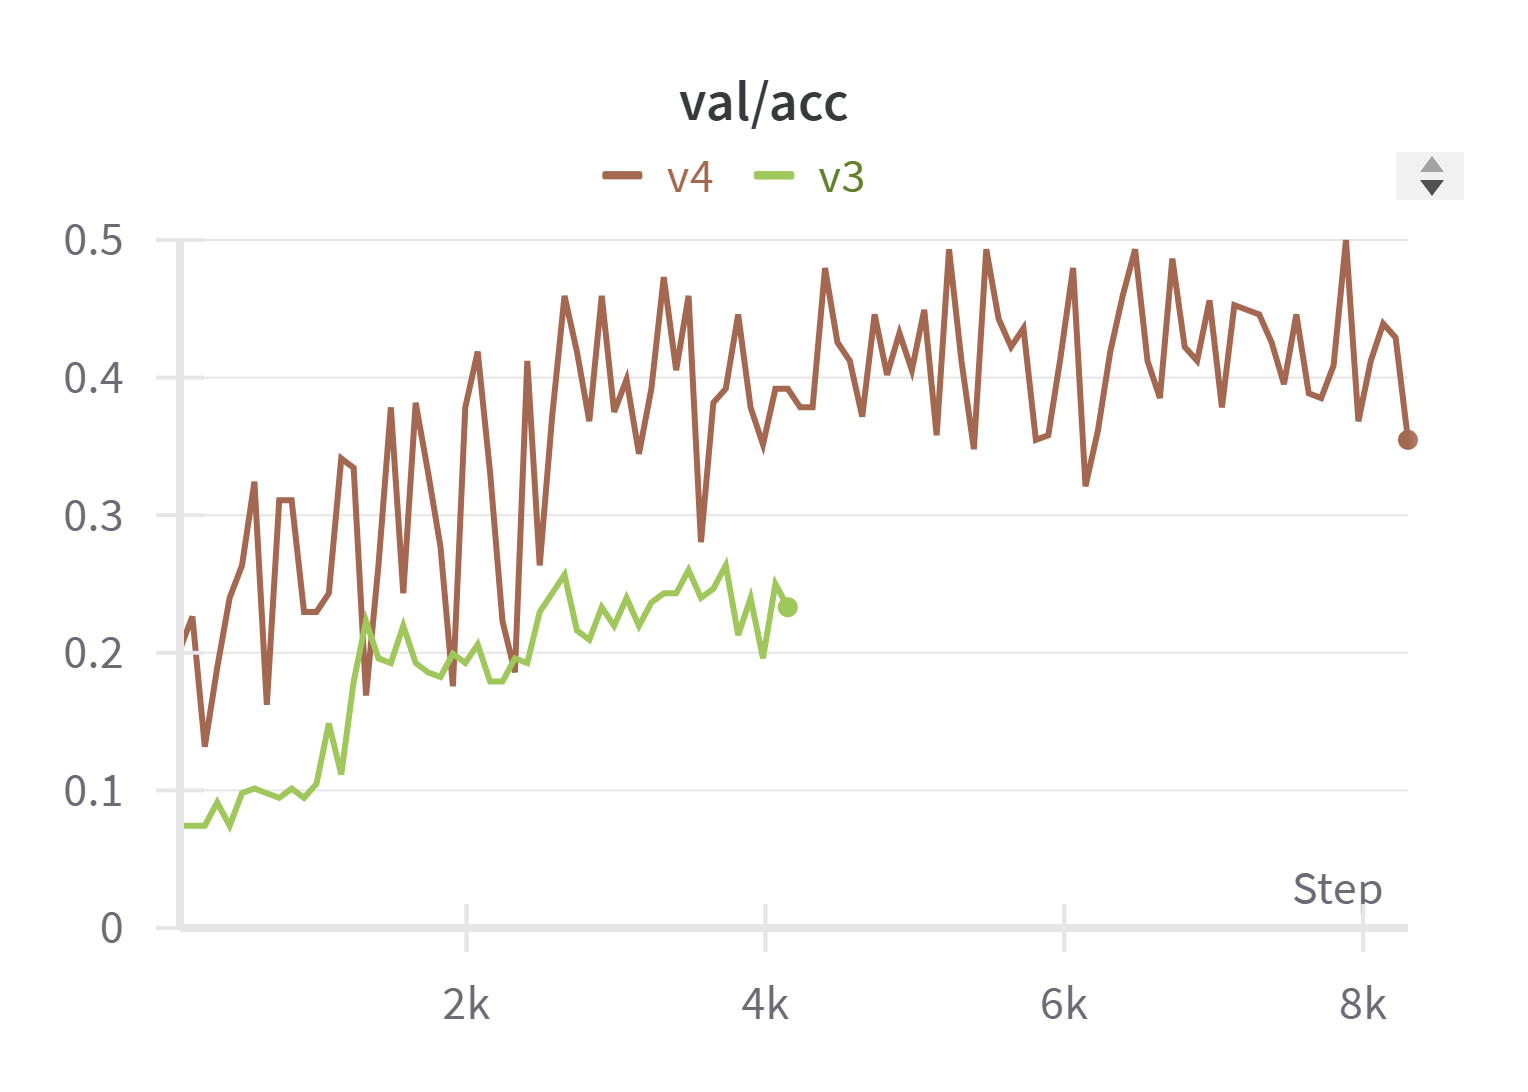

Training loss has decreased along all the training and also validation accuracy has reached some pretty good values.

Now that we have a well built model, we can try to regularize it. First of all we introduce data augmentation.

#### Augmentation

In [30]:
data_transforms = T.Compose([
                        T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.RandomVerticalFlip(),
                        T.RandomRotation(180),                              # rotation in all directions
                        T.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # translations of 10%
                        T.RandomPerspective(distortion_scale=0.1, p=0.5),
                        T.ToTensor()
                    ])

data_train_augm = GroceryStoreDataset(split="train", transform=data_transforms)
data_val_augm = GroceryStoreDataset(split="val", transform=data_resizing)

loader_train_augm = DataLoader(
    data_train_augm,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val_augm = DataLoader(
    data_val_augm,
    batch_size=cfg["batch_size"],
    shuffle=False
)

In [31]:
model = V4(n_classes=len(classes))
if next(model.parameters()).device != device:
    model.to(device)
cfg["run_name"] = "v4_augm"
cfg["num_epochs"]=100
trainer = Trainer(
    model,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params(data_transforms)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train/acc,▁▂▂▃▃▃▄▄▄▅▅▅▄▅▆▅▆▅▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇████▇█
train/loss,█▇▆▇▅▅▅▅▅▅▄▆▇▄▅▃▄▄▃▃▁▃▁▃▃▂▂▃▁▂▂▂▂▃▂▁▂▃▁▂
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▄▃▄▄▃▅▄▅▄▅▄▄▅▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▅▇▇▆█▇▇
val/loss,▇█▃▆▃▄▆▂▂▁▄▃▄▄▃▄▃▆▄▁▁▂▁▁▂▂▃▂▂▂▃▁▂▆▂▂▃▃▃▃
train/acc,0.80985
train/loss,0.59174
train/lr,0.001
val/acc,0.4527
val/loss,2.28468


Best val acc = 0.520


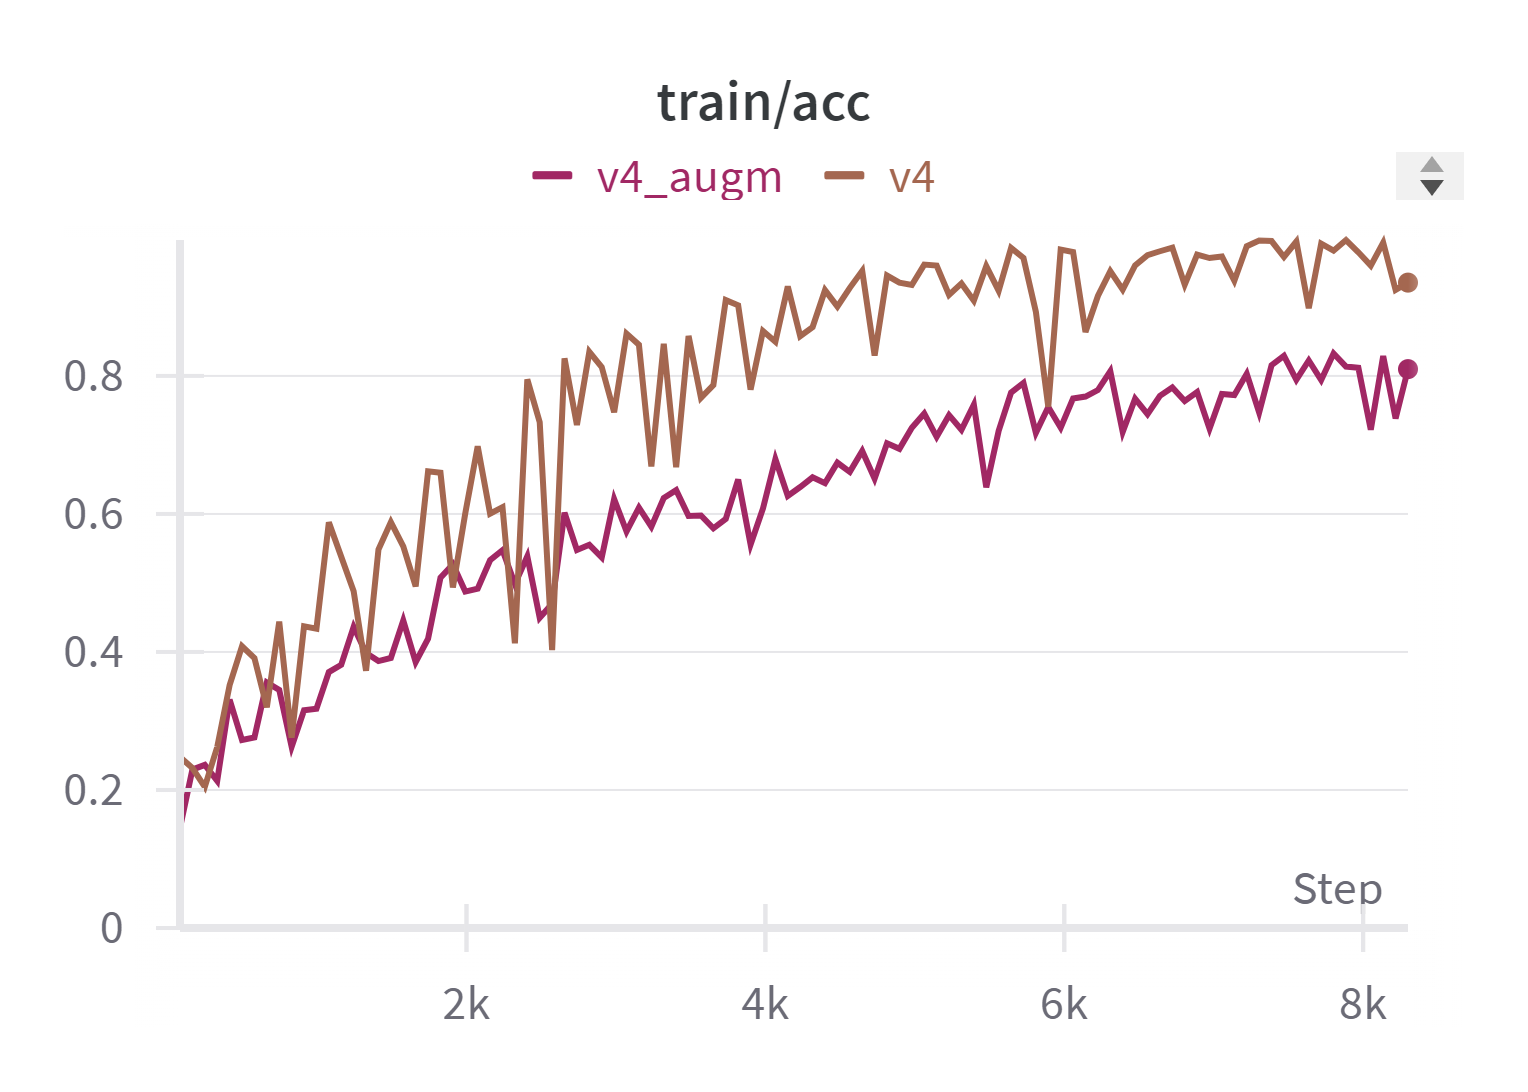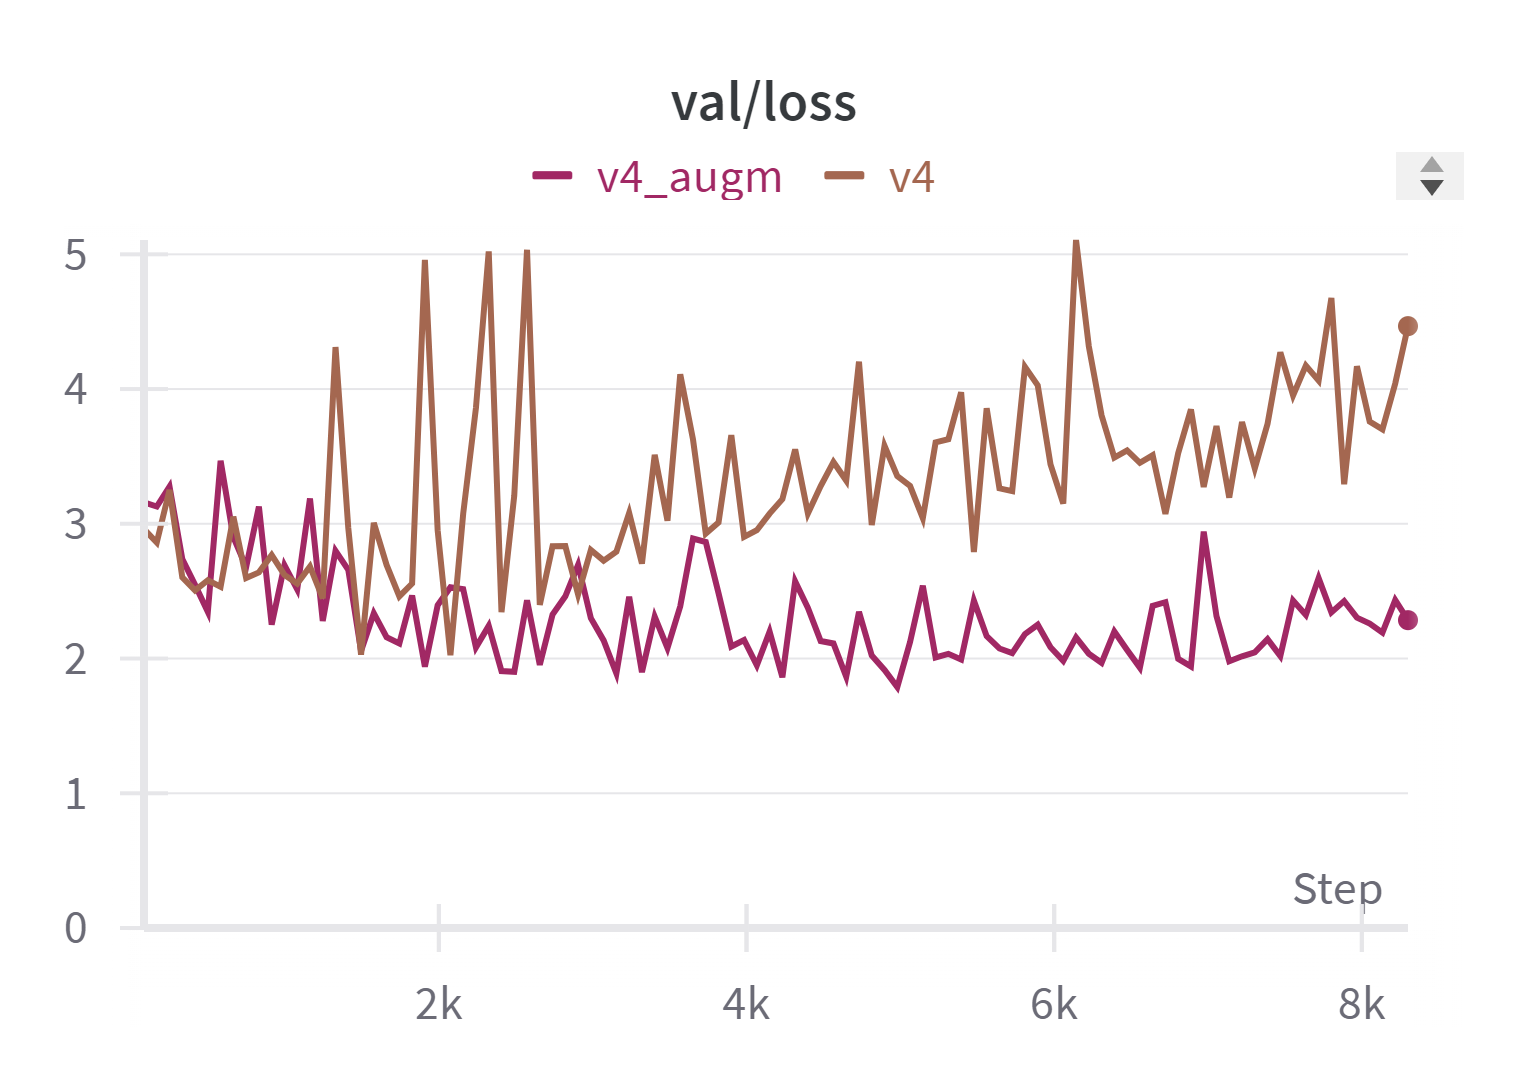

As we can see from the plots, data augmentation makes the training harder(lower train accuracy) but it also decrease the validation loss and it allows us to reach 0.52 accuracy.

#### Regularization

In this final section we add other regularization techniques such as $l_2$ regularization(weight decay) and OneCycle learning rate scheduling.

In [32]:
cfg["scheduler"] = OneCycleLR
cfg["scheduler_params"] = {"pct_start": 0.25}
cfg["num_epochs"] = 100
cfg["optimizer"] = AdamW
cfg["optimizer_params"]["lr"] = 0.001
cfg["optimizer_params"]["weight_decay"] = 5e-3

In [33]:
model = V4(n_classes=len(classes))
if next(model.parameters()).device != device:
    model.to(device)
cfg["run_name"] = "v4_augm_reg"

trainer = Trainer(
    model,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
# Log results
trainer.save_model_params(data_transforms)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train/acc,▁▂▃▃▁▃▃▄▄▄▅▅▄▆▅▅▆▆▆▆▇▇▅▇▇▇▇▇▇███████████
train/loss,█▆▄▅▅▅▄▅▄▃▄▃▃▃▂▃▃▃▃▂▄▂▂▂▁▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁
train/lr,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val/acc,▁▂▃▂▁▃▅▆▄▅▅▅▄▅▆▅▆▆▅▇▆█▇▆▇▇█▇▇█▇▇█▇███▇██
val/loss,█▆▃▅▇▅▂▂▆▅▃▃▄▃▂▄▂▄▂▃▃▁▄▃▁▂▂▄▃▂▃▂▂▃▂▂▂▂▂▂
train/acc,0.96591
train/loss,0.12521
train/lr,0.0
val/acc,0.60473
val/loss,1.98659


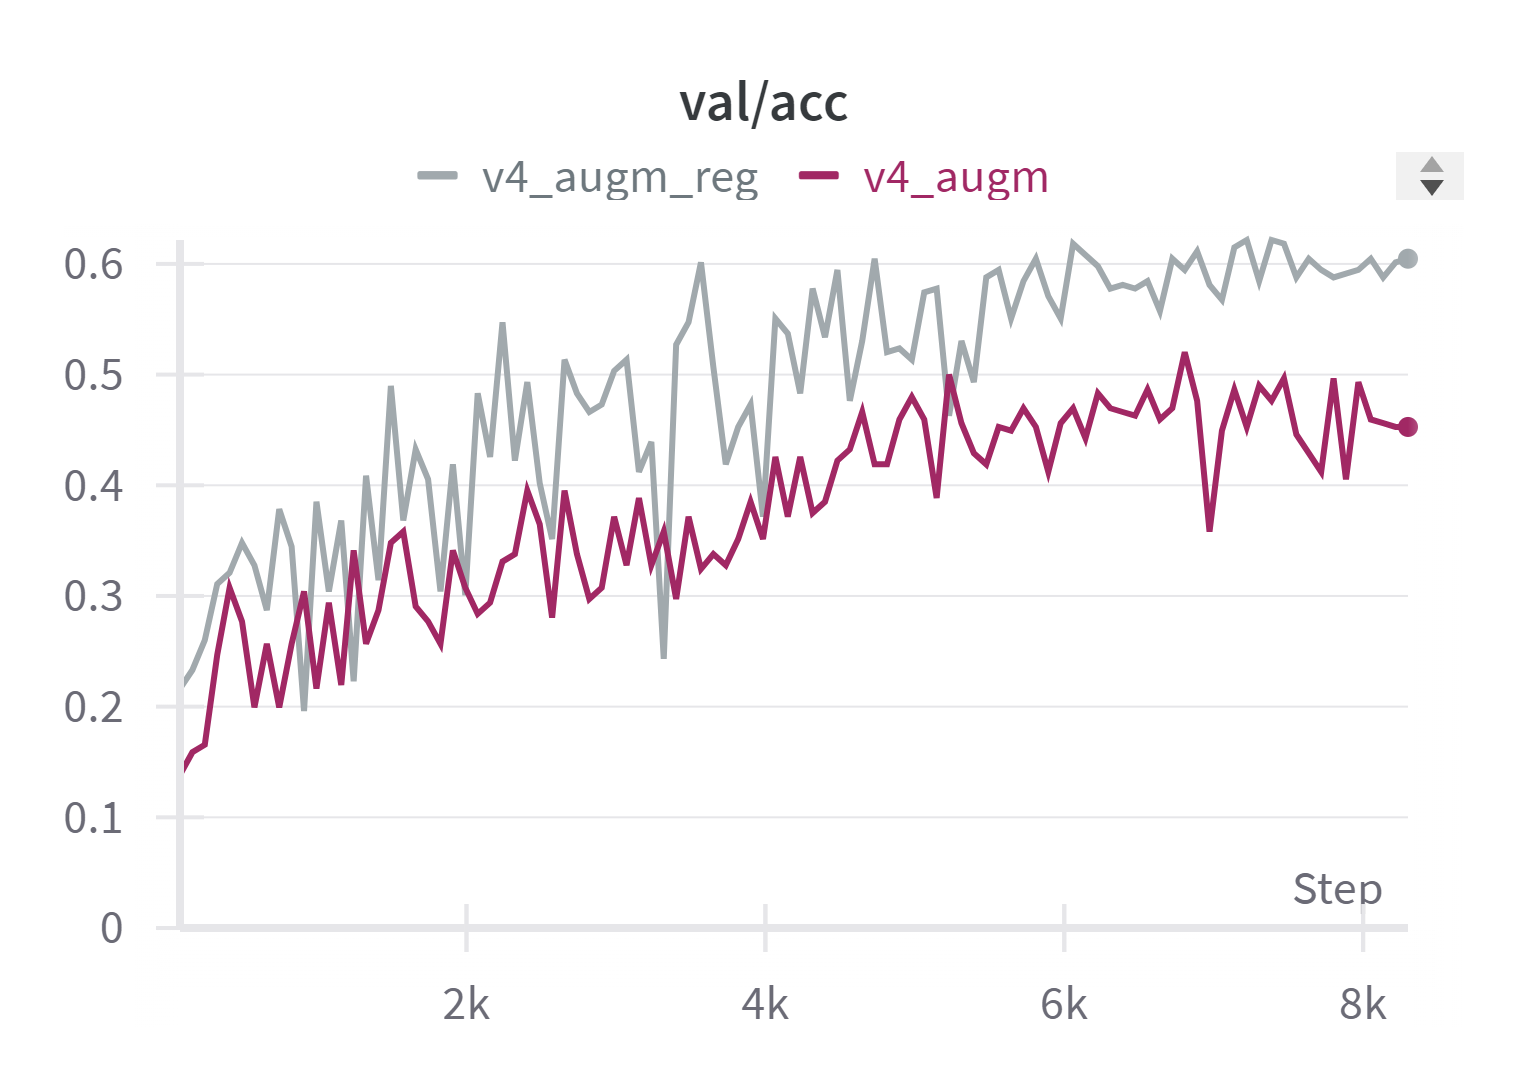

In [35]:
print(f"Best val acc = {trainer.best_acc:.3f}")

Best val acc = 0.622


This final regularization has allowed us to reach the target of 0.6 accuracy on the validation set.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
2. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### 1) Fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [ ]:
cfg = {
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 100,
    "optimizer":AdamW,
    "optimizer_params":{
      "lr": 1e-3,
      "weight_decay":5e-4
    },
    "scheduler":OneCycleLR,
    "scheduler_params":{"pct_start":0.25},
    "loss":F.cross_entropy,
    "loss_params":{}
}

In [ ]:
# Pretrained ResNet-18 on ImageNet-1K (V1)
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

## First train
cfg["run_name"] = "ResNet-18_pretrained_full_net"
trainer = Trainer(
    pt_resnet18,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davidesonno (davidecrociati). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train/acc,▁▆▇▆▆▆▄▃▃▄▆▅▆▇▇▇▇▇█▇▇█▇█████████████████
train/loss,█▄▂▂▃▃▂▂▂▅▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train/lr,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val/acc,▁▅▆▆▄▅▂▃▂▃▆▄▅▆▅▆▅▇▆▅▇▆▅▅▇▆▇▇████████████
val/loss,▄▂▂▂▃▃▅▅█▄▂▃▃▂▃▂▃▂▂▃▂▃▄▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.99053
train/loss,0.03707
train/lr,0.0
val/acc,0.87838
val/loss,0.46894


In [ ]:
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Best val acc (intermediate) = 0.878


### 2) Tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`.

In [36]:
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]
data_transforms = T.Compose([
    T.RandomResizedCrop(cfg["crop_size"]),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(180),                              # rotation in all directions
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # translations of 10%
    T.RandomPerspective(distortion_scale=0.1, p=0.5),
    T.ToTensor(),
    T.Normalize(mean_image_net, std_image_net)
])

# Datasets
data_train_augm = GroceryStoreDataset(split="train", transform=data_transforms)
data_val_augm = GroceryStoreDataset(split="val", transform=data_resizing)

In [37]:
loader_train_augm = DataLoader(
    data_train_augm,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val_augm = DataLoader(
    data_val_augm,
    batch_size=cfg["batch_size"],
    shuffle=False
)

In [38]:
cfg = {
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 20,
    "optimizer":AdamW,
    "optimizer_params":{
      "lr": 3e-4,
      "weight_decay":5e-4
    },
    "scheduler":None,
    "scheduler_params":{"pct_start":0.25},
    "loss":F.cross_entropy,
    "loss_params":{},
}

In [39]:
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

# First train
cfg["run_name"] = "ResNet-18_pretrained_initial_training_2_20_constant"
trainer = Trainer(
    pt_resnet18,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
train/loss,█▇▆▆▅▄▄▄▄▃▄▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▅▆▅▇▆█▇▇▇▆▆▇▆▇▆▆█▇
val/loss,█▆▅▃▃▂▃▁▂▂▂▂▂▁▂▂▂▂▁▂
train/acc,0.82121
train/loss,0.73728
train/lr,0.0003
val/acc,0.31081
val/loss,2.4647


Best val acc (intermediate) = 0.334


In [40]:
## Load the state of the best accuracy
sd = torch.load(f"ckpts/ResNet-18_pretrained_initial_training_2_20_constant.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

## Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning_2_20_constant"
cfg["optimizer_params"]["lr"] *= 0.1
trainer = Trainer(
    pt_resnet18,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▄▅▅▆▆▇▇▇███▇███████
train/loss,█▆▅▅▆▄▄▅▃▃▃▂▂▄▂▃▃▃▁▂▄▂▃▁▃▂▃▁▂▂▁▂▁▂▂▂▂▂▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▃█▅▆▅▁▃▅▆▂▂▄▄▄▂▅▄▂▁▂
val/loss,▁▁▃▃▃▅▄▄▅▆▆▆▆██▇▇▆▇█
train/acc,0.97424
train/loss,0.0992
train/lr,3e-05
val/acc,0.25
val/loss,3.64889


Best val acc = 0.321


In [ ]:
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Best val acc (intermediate) = 0.902


In [ ]:
cfg = {
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 20,
    "optimizer":AdamW,
    "optimizer_params":{
      "lr": 5e-4,
      "weight_decay":1e-4
    },
    "scheduler":None,
    "scheduler_params":{"pct_start":0.3},
    "loss":F.cross_entropy,
    "loss_params":{},
}

In [ ]:
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

# First train
cfg["run_name"] = "ResNet-18_pretrained_initial_training_2_20_constant1e-4"
trainer = Trainer(
    pt_resnet18,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▄▅▆▆▆▇▇▇▇▇█▇███████
train/loss,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▂▂▂▂▂▂▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▃▄▄▆▆▆▇▇▇▇▇██▇█████
val/loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/acc,0.85189
train/loss,0.61894
train/lr,0.0005
val/acc,0.67568
val/loss,0.99205


Best val acc (intermediate) = 0.676


In [ ]:
## Load the state of the best accuracy
sd = torch.load(f"ckpts/ResNet-18_pretrained_initial_training_2_20_constant1e-4.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

## Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning_2_20_constant1e-4"
cfg["optimizer_params"]["lr"] *= 0.1
# cfg["num_epochs"] = 10
# cfg["scheduler_params"]["pct_start"]=0.5
trainer = Trainer(
    pt_resnet18,
    cfg,
    loader_train_augm,
    loader_val_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▄▄▅▅▆▆▆▇▆▇▇▇▇▇▇██▇▇
train/loss,█▅▅▄▅▃▃▄▃▂▂▂▃▅▂▃▃▃▄▆▄▁▁▄▂▃▁▂▃▃▃▄▁▆▁▂▂▁▄▃
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▃▄▆▆▅▄▇▆▅▆▆▆▇▇▆▇▆▇█
val/loss,█▅▄▄▃▄▄▂▂▂▂▁▂▁▁▃▂▁▂▁
train/acc,0.97424
train/loss,0.0813
train/lr,5e-05
val/acc,0.89865
val/loss,0.36793


Best val acc (intermediate) = 0.899
